<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas

In [13]:
import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
COLAB_DIR = join(HOME, 'Colab Notebooks')
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,TICKER,DTYYYYMMDD,OPEN,HIGH,LOW,CLOSE,VOL,VAL,NUM_OF_TRANSACTIONS,CLOSE_ONE_DAY_BEFORE
0,مظنه,20191120,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
1,مظنه,20191123,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
2,مظنه,20191124,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
3,مظنه,20191125,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
4,مظنه,20191126,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0


In [0]:
max_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.max).reset_index().sort_values('VOL', ascending=False)

In [58]:
len(max_vol_per_ticker[ max_vol_per_ticker['VOL'] != 0 ])

1422

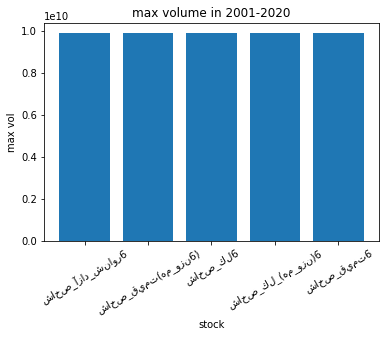

In [62]:
 five_first_stocks_with_max_vol = max_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_max_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_max_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('max vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_max_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('max volume in 2001-2020')
 plt.show()